# Summarization Model Evaluation

This notebook evaluates different summarization techniques using the CNN/DailyMail dataset.

## Methods to Evaluate
- **Extractive**: TextRank, LexRank
- **Abstractive**: BART, T5, Pegasus, LED, LongT5

## Metrics
- **ROUGE-1, ROUGE-2, ROUGE-L**: N-gram overlap with reference summaries
- **BERTScore**: Semantic similarity using BERT embeddings
- **METEOR**: Considers synonyms and paraphrasing
- **Compression Ratio**: Summary length vs original length

## 1. Setup and Imports

In [1]:
import sys
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Add project root to path to import from src/
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Import summarization module
from src.summarization import get_summarizer

print(f"Project root: {project_root}")

Project root: /home/amanda/taf/sl-newspaper-bias-analysis


In [2]:
import os
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY_HERE"
os.environ["GOOGLE_API_KEY"] = "YOUR_API_KEY_HERE"
os.environ["ANTHROPIC_API_KEY"] = "YOUR_API_KEY_HERE"

## 1.1. Setup Summary Caching

In [ ]:
import json
import hashlib
from pathlib import Path
from datetime import datetime

# Cache configuration
CACHE_DIR = Path("cache/summarization/cnn_dailymail")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
USE_CACHE = True  # Set to False to regenerate all summaries

def get_article_hash(article_text: str) -> str:
    """Generate deterministic hash for article text."""
    return hashlib.sha256(article_text.encode('utf-8')).hexdigest()

def get_cache_path(method: str, summary_length: str) -> Path:
    """Get cache file path for method and length."""
    return CACHE_DIR / f"{method}_{summary_length}.json"

def load_cache(method: str, summary_length: str) -> dict:
    """Load cached summaries if available."""
    cache_path = get_cache_path(method, summary_length)
    if not USE_CACHE or not cache_path.exists():
        return None
    
    with open(cache_path, 'r') as f:
        return json.load(f)

def save_cache(method: str, summary_length: str, summaries: dict,
               sample_size: int, random_seed: int):
    """Save summaries to cache with metadata."""
    cache_path = get_cache_path(method, summary_length)
    
    cache_data = {
        "metadata": {
            "method": method,
            "summary_length": summary_length,
            "dataset": "cnn_dailymail",
            "dataset_version": "3.0.0",
            "sample_size": sample_size,
            "random_seed": random_seed,
            "created_at": datetime.now().isoformat(),
            "last_updated": datetime.now().isoformat()
        },
        "summaries": summaries
    }
    
    with open(cache_path, 'w') as f:
        json.dump(cache_data, f, indent=2)

def get_summaries_from_cache(method: str, summary_length: str,
                             articles: list) -> tuple:
    """
    Get summaries from cache if available and complete.
    
    Returns:
        Tuple of (summaries list, is_from_cache bool)
        summaries is None if cache is incomplete
    """
    cache_data = load_cache(method, summary_length)
    if cache_data is None:
        return None, False
    
    # Generate article hashes
    article_hashes = [get_article_hash(article) for article in articles]
    
    # Check if all articles are in cache
    cached_summaries = cache_data.get("summaries", {})
    if not all(h in cached_summaries for h in article_hashes):
        print(f"  Cache incomplete for {method}, will regenerate missing summaries")
        return None, False
    
    # Return summaries in correct order
    summaries = [cached_summaries[h] for h in article_hashes]
    print(f"  ✓ Loaded {len(summaries)} summaries from cache")
    return summaries, True

print("Cache functions loaded. Cache directory:", CACHE_DIR)
print(f"Cache mode: {'ENABLED' if USE_CACHE else 'DISABLED'}")

Cache functions loaded. Cache directory: cache/cnn_dailymail
Cache mode: ENABLED


In [4]:
# Install evaluation dependencies if needed
# Uncomment and run if packages are missing

# !pip install datasets rouge-score bert-score nltk

In [5]:
# Import evaluation libraries
from datasets import load_dataset
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import nltk

# Download NLTK data for METEOR
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("All evaluation libraries loaded successfully!")

All evaluation libraries loaded successfully!


## 2. Load CNN/DailyMail Dataset

In [6]:
# Load CNN/DailyMail dataset (version 3.0.0)
# This is the standard benchmark dataset for news summarization
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")

print(f"Total test samples: {len(dataset)}")
print(f"\nDataset features: {dataset.features}")

Loading CNN/DailyMail dataset...
Total test samples: 11490

Dataset features: {'article': Value('string'), 'highlights': Value('string'), 'id': Value('string')}


In [7]:
# Sample a subset for evaluation (full dataset takes too long)
# Adjust SAMPLE_SIZE based on your compute resources
SAMPLE_SIZE = 100  # Use 100 samples for reasonable evaluation time
RANDOM_SEED = 42

# Shuffle and select samples
eval_dataset = dataset.shuffle(seed=RANDOM_SEED).select(range(SAMPLE_SIZE))

print(f"Evaluation sample size: {len(eval_dataset)}")

# Preview a sample
sample = eval_dataset[0]
print(f"\n--- Sample Article (first 500 chars) ---")
print(sample['article'][:500])
print(f"\n--- Reference Summary ---")
print(sample['highlights'])

Evaluation sample size: 100

--- Sample Article (first 500 chars) ---
(CNN) I see signs of a revolution everywhere. I see it in the op-ed pages of the newspapers, and on the state ballots in nearly half the country. I see it in politicians who once preferred to play it safe with this explosive issue but are now willing to stake their political futures on it. I see the revolution in the eyes of sterling scientists, previously reluctant to dip a toe into this heavily stigmatized world, who are diving in head first. I see it in the new surgeon general who cites data 

--- Reference Summary ---
CNN's Dr. Sanjay Gupta says we should legalize medical marijuana now .
He says he knows how easy it is do nothing "because I did nothing for too long"


In [8]:
# Prepare data as lists for easier processing
articles = eval_dataset['article']
references = eval_dataset['highlights']

# Basic statistics
article_lengths = [len(a.split()) for a in articles]
reference_lengths = [len(r.split()) for r in references]

print(f"Article word count - Mean: {np.mean(article_lengths):.0f}, Median: {np.median(article_lengths):.0f}")
print(f"Reference word count - Mean: {np.mean(reference_lengths):.0f}, Median: {np.median(reference_lengths):.0f}")

Article word count - Mean: 621, Median: 521
Reference word count - Mean: 53, Median: 51


## 3. Define Evaluation Functions

In [9]:
def validate_summary_completeness(predictions: list) -> dict:
    """
    Check for incomplete summaries (mid-sentence truncation).

    Returns dict with validation statistics.
    """
    def is_complete(text):
        if not text or not text.strip():
            return False
        text = text.strip()
        # Check if ends with sentence-ending punctuation
        if text.endswith(('.', '!', '?')):
            return True
        # Check if ends with quote and has punctuation before it
        if text.endswith(("'", '"', "'", '"')) and len(text) > 1:
            return text[-2] in '.!?'
        return False

    complete_count = sum(1 for p in predictions if p and is_complete(p))
    incomplete_count = sum(1 for p in predictions if p and not is_complete(p))
    empty_count = sum(1 for p in predictions if not p or not p.strip())

    return {
        'complete': complete_count,
        'incomplete': incomplete_count,
        'empty': empty_count,
        'completion_rate': complete_count / len(predictions) if predictions else 0
    }

def calculate_rouge_scores(predictions: list, references: list) -> dict:
    """
    Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores.
    
    Returns dict with precision, recall, and F1 for each metric.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for pred, ref in zip(predictions, references):
        if not pred or not pred.strip():
            for key in scores:
                scores[key].append({'precision': 0, 'recall': 0, 'fmeasure': 0})
            continue
            
        result = scorer.score(ref, pred)
        for key in scores:
            scores[key].append({
                'precision': result[key].precision,
                'recall': result[key].recall,
                'fmeasure': result[key].fmeasure
            })
    
    # Aggregate scores
    aggregated = {}
    for metric in scores:
        aggregated[f'{metric}_precision'] = np.mean([s['precision'] for s in scores[metric]])
        aggregated[f'{metric}_recall'] = np.mean([s['recall'] for s in scores[metric]])
        aggregated[f'{metric}_f1'] = np.mean([s['fmeasure'] for s in scores[metric]])
    
    return aggregated


def calculate_bert_scores(predictions: list, references: list) -> dict:
    """
    Calculate BERTScore for semantic similarity.
    
    Returns dict with precision, recall, and F1.
    """
    # Filter out empty predictions
    valid_pairs = [(p, r) for p, r in zip(predictions, references) if p and p.strip()]
    
    if not valid_pairs:
        return {'bertscore_precision': 0, 'bertscore_recall': 0, 'bertscore_f1': 0}
    
    valid_preds, valid_refs = zip(*valid_pairs)
    
    P, R, F1 = bert_score(list(valid_preds), list(valid_refs), lang='en', verbose=False)
    
    return {
        'bertscore_precision': P.mean().item(),
        'bertscore_recall': R.mean().item(),
        'bertscore_f1': F1.mean().item()
    }


def calculate_meteor_scores(predictions: list, references: list) -> dict:
    """
    Calculate METEOR score.
    
    Returns dict with mean METEOR score.
    """
    scores = []
    
    for pred, ref in zip(predictions, references):
        if not pred or not pred.strip():
            scores.append(0)
            continue
        
        # Tokenize for METEOR
        pred_tokens = word_tokenize(pred.lower())
        ref_tokens = word_tokenize(ref.lower())
        
        score = meteor_score([ref_tokens], pred_tokens)
        scores.append(score)
    
    return {'meteor': np.mean(scores)}


def calculate_compression_ratio(predictions: list, articles: list) -> dict:
    """
    Calculate compression ratio (summary length / article length).
    """
    ratios = []
    
    for pred, article in zip(predictions, articles):
        if not pred or not pred.strip():
            ratios.append(0)
            continue
        
        pred_words = len(pred.split())
        article_words = len(article.split())
        
        ratio = pred_words / article_words if article_words > 0 else 0
        ratios.append(ratio)
    
    return {
        'compression_ratio_mean': np.mean(ratios),
        'compression_ratio_std': np.std(ratios)
    }

In [10]:
def evaluate_summarizer(method: str, articles: list, references: list, 
                        summary_length: str = "medium") -> dict:
    """
    Run a summarizer on all articles and calculate all metrics.
    
    Checks cache first to avoid regenerating summaries.
    
    Args:
        method: Summarization method (textrank, lexrank, bart, t5, etc.)
        articles: List of article texts
        references: List of reference summaries
        summary_length: Target summary length (short, medium, long)
    
    Returns:
        Dictionary with all metrics and timing info
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {method.upper()}")
    print(f"{'='*60}")
    
    # Check cache first
    cached_summaries, is_cached = get_summaries_from_cache(method, summary_length, articles)
    
    if cached_summaries is not None:
        predictions = cached_summaries
        processing_times = [0.0] * len(articles)  # No processing time for cached results
        failed_count = sum(1 for p in predictions if not p or not p.strip())
        print(f"Using cached summaries. Failed: {failed_count}/{len(articles)}")
    else:
        # Generate summaries (existing code)
        print("Generating summaries...")
        config = {
            "method": method,
            "summary_length": summary_length,
            "chunk_long_articles": True
        }
        
        try:
            summarizer = get_summarizer(config)
        except Exception as e:
            print(f"Failed to initialize {method}: {e}")
            return None, None
        
        predictions = []
        processing_times = []
        failed_count = 0
        
        for article in tqdm(articles, desc=f"Summarizing with {method}"):
            start_time = time.time()
            try:
                summary = summarizer.summarize(article)
                predictions.append(summary if summary else "")
                if not summary:
                    failed_count += 1
            except Exception as e:
                print(f"Error: {e}")
                predictions.append("")
                failed_count += 1
            
            processing_times.append(time.time() - start_time)
        
        print(f"\nSummarization complete. Failed: {failed_count}/{len(articles)}")
        
        # Save to cache
        article_hashes = [get_article_hash(article) for article in articles]
        summaries_dict = dict(zip(article_hashes, predictions))
        save_cache(method, summary_length, summaries_dict, len(articles), RANDOM_SEED)
        print(f"  ✓ Saved summaries to cache")
    
    # Validate output quality
    validation = validate_summary_completeness(predictions)
    print(f"\nOutput Quality:")
    print(f"  Complete summaries: {validation['complete']}/{len(predictions)} ({validation['completion_rate']:.1%})")
    print(f"  Incomplete summaries: {validation['incomplete']}")
    print(f"  Empty summaries: {validation['empty']}")
    if validation['incomplete'] > 0:
        print(f"  ⚠️  Warning: {validation['incomplete']} summaries are truncated mid-sentence!")
    
    # Calculate all metrics
    print("\nCalculating ROUGE scores...")
    rouge_scores = calculate_rouge_scores(predictions, references)
    
    print("Calculating BERTScore...")
    bert_scores = calculate_bert_scores(predictions, references)
    
    print("Calculating METEOR score...")
    meteor_scores = calculate_meteor_scores(predictions, references)
    
    print("Calculating compression ratio...")
    compression = calculate_compression_ratio(predictions, articles)
    
    # Combine all results
    results = {
        'method': method,
        'num_samples': len(articles),
        'failed_count': failed_count,
        'complete_count': validation['complete'],
        'incomplete_count': validation['incomplete'],
        'completion_rate': validation['completion_rate'],
        'avg_time_seconds': np.mean(processing_times),
        'total_time_seconds': sum(processing_times),
        **rouge_scores,
        **bert_scores,
        **meteor_scores,
        **compression
    }
    
    # Print summary
    print(f"\n--- Results for {method.upper()} ---")
    print(f"ROUGE-1 F1: {results['rouge1_f1']:.4f}")
    print(f"ROUGE-2 F1: {results['rouge2_f1']:.4f}")
    print(f"ROUGE-L F1: {results['rougeL_f1']:.4f}")
    print(f"BERTScore F1: {results['bertscore_f1']:.4f}")
    print(f"METEOR: {results['meteor']:.4f}")
    print(f"Avg Time: {results['avg_time_seconds']:.2f}s {'(cached)' if is_cached else ''}")
    
    return results, predictions

## 4. Run Evaluation on All Methods

In [11]:
# Define methods to evaluate
# Note: After fixing the bug, transformer models now generate summaries
# using natural stopping (EOS tokens) rather than hard token limits.
# Summary lengths may vary more than before, but outputs will be complete.

METHODS_TO_EVALUATE = [
    # Extractive methods (fast, fixed length)
    "textrank",
    "lexrank",

    # Abstractive transformer methods (natural length, complete sentences)
    "bart",
    "pegasus",
    "t5",
    "led",
    "longt5",
    "bigbird-pegasus",
    
    # LLM-based methods (requires API keys - uncomment to use)
    # "claude",  # Requires ANTHROPIC_API_KEY
    "gpt",     # Requires OPENAI_API_KEY
    "gemini",  # Requires GOOGLE_API_KEY
]

print(f"Methods to evaluate: {METHODS_TO_EVALUATE}")

Methods to evaluate: ['textrank', 'lexrank', 'bart', 'pegasus', 't5', 'led', 'longt5', 'bigbird-pegasus', 'gpt', 'gemini']


In [12]:
# Run evaluation for all methods
all_results = []
all_predictions = {}

for method in METHODS_TO_EVALUATE:
    result, predictions = evaluate_summarizer(
        method=method,
        articles=articles,
        references=references,
        summary_length="short"
    )
    
    if result:
        all_results.append(result)
        all_predictions[method] = predictions

print(f"\n\n{'='*60}")
print("EVALUATION COMPLETE!")
print(f"{'='*60}")


Evaluating: TEXTRANK
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 99/100 (99.0%)
  Incomplete summaries: 1
  Empty summaries: 0
  ⚠️  Warning: 1 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for TEXTRANK ---
ROUGE-1 F1: 0.3472
ROUGE-2 F1: 0.1322
ROUGE-L F1: 0.2211
BERTScore F1: 0.8631
METEOR: 0.3445
Avg Time: 0.00s (cached)

Evaluating: LEXRANK
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 100/100 (100.0%)
  Incomplete summaries: 0
  Empty summaries: 0

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for LEXRANK ---
ROUGE-1 F1: 0.3486
ROUGE-2 F1: 0.1285
ROUGE-L F1: 0.2185
BERTScore F1: 0.8626
METEOR: 0.3210
Avg Time: 0.00s (cached)

Evaluating: BART
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 92/100 (92.0%)
  Incomplete summaries: 8
  Empty summaries: 0
  ⚠️  Warning: 8 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for BART ---
ROUGE-1 F1: 0.4129
ROUGE-2 F1: 0.1948
ROUGE-L F1: 0.2851
BERTScore F1: 0.8752
METEOR: 0.3888
Avg Time: 0.00s (cached)

Evaluating: PEGASUS
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 98/100 (98.0%)
  Incomplete summaries: 2
  Empty summaries: 0
  ⚠️  Warning: 2 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for PEGASUS ---
ROUGE-1 F1: 0.2761
ROUGE-2 F1: 0.0907
ROUGE-L F1: 0.1731
BERTScore F1: 0.8580
METEOR: 0.1976
Avg Time: 0.00s (cached)

Evaluating: T5
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 96/100 (96.0%)
  Incomplete summaries: 4
  Empty summaries: 0
  ⚠️  Warning: 4 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for T5 ---
ROUGE-1 F1: 0.3626
ROUGE-2 F1: 0.1567
ROUGE-L F1: 0.2425
BERTScore F1: 0.8633
METEOR: 0.3603
Avg Time: 0.00s (cached)

Evaluating: LED
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 7/100 (7.0%)
  Incomplete summaries: 93
  Empty summaries: 0
  ⚠️  Warning: 93 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for LED ---
ROUGE-1 F1: 0.2796
ROUGE-2 F1: 0.1339
ROUGE-L F1: 0.1928
BERTScore F1: 0.8575
METEOR: 0.3974
Avg Time: 0.00s (cached)

Evaluating: LONGT5
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 99/100 (99.0%)
  Incomplete summaries: 1
  Empty summaries: 0
  ⚠️  Warning: 1 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for LONGT5 ---
ROUGE-1 F1: 0.3247
ROUGE-2 F1: 0.1167
ROUGE-L F1: 0.2118
BERTScore F1: 0.8572
METEOR: 0.2621
Avg Time: 0.00s (cached)

Evaluating: BIGBIRD-PEGASUS
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 23/100 (23.0%)
  Incomplete summaries: 77
  Empty summaries: 0
  ⚠️  Warning: 77 summaries are truncated mid-sentence!

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for BIGBIRD-PEGASUS ---
ROUGE-1 F1: 0.0911
ROUGE-2 F1: 0.0085
ROUGE-L F1: 0.0702
BERTScore F1: 0.7724
METEOR: 0.0810
Avg Time: 0.00s (cached)

Evaluating: GPT
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 100/100 (100.0%)
  Incomplete summaries: 0
  Empty summaries: 0

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for GPT ---
ROUGE-1 F1: 0.4001
ROUGE-2 F1: 0.1505
ROUGE-L F1: 0.2557
BERTScore F1: 0.8770
METEOR: 0.3585
Avg Time: 0.00s (cached)

Evaluating: GEMINI
  ✓ Loaded 100 summaries from cache
Using cached summaries. Failed: 0/100

Output Quality:
  Complete summaries: 100/100 (100.0%)
  Incomplete summaries: 0
  Empty summaries: 0

Calculating ROUGE scores...
Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating METEOR score...
Calculating compression ratio...

--- Results for GEMINI ---
ROUGE-1 F1: 0.4135
ROUGE-2 F1: 0.1685
ROUGE-L F1: 0.2739
BERTScore F1: 0.8764
METEOR: 0.3493
Avg Time: 0.00s (cached)


EVALUATION COMPLETE!


## 5. Results Analysis

In [13]:
results_df = pd.DataFrame(all_results)

display_columns = [
    'method', 
    'rouge1_f1', 'rouge2_f1', 'rougeL_f1',
    'bertscore_f1', 'meteor',
    'compression_ratio_mean', 'avg_time_seconds'
]

display_df = results_df[display_columns].copy()
display_df.columns = [
    'Method', 
    'ROUGE-1', 'ROUGE-2', 'ROUGE-L',
    'BERTScore', 'METEOR',
    'Compression', 'Avg Time (s)'
]

for col in display_df.columns[1:]:
    if col != 'Avg Time (s)':
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    else:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}")

print("\n" + "="*80)
print("SUMMARIZATION EVALUATION RESULTS")
print("="*80)
display(display_df)


SUMMARIZATION EVALUATION RESULTS


,Method,ROUGE-1,ROUGE-2,ROUGE-L,BERTScore,METEOR,Compression,Avg Time (s)
0,textrank,0.3472,0.1322,0.2211,0.8631,0.3445,0.1789,0.00
1,lexrank,0.3486,0.1285,0.2185,0.8626,0.3210,0.1459,0.00
2,bart,0.4129,0.1948,0.2851,0.8752,0.3888,0.1353,0.00
3,pegasus,0.2761,0.0907,0.1731,0.8580,0.1976,0.0626,0.00
4,t5,0.3626,0.1567,0.2425,0.8633,0.3603,0.1662,0.00
5,led,0.2796,0.1339,0.1928,0.8575,0.3974,0.4048,0.00
6,longt5,0.3247,0.1167,0.2118,0.8572,0.2621,0.0997,0.00
7,bigbird-pegasus,0.0911,0.0085,0.0702,0.7724,0.0810,0.2745,0.00
8,gpt,0.4001,0.1505,0.2557,0.8770,0.3585,0.1348,0.00
9,gemini,0.4135,0.1685,0.2739,0.8764,0.3493,0.1171,0.00


In [14]:
results_df.to_csv('summarization_evaluation_results.csv', index=False)
print("Results saved to summarization_evaluation_results.csv")

Results saved to summarization_evaluation_results.csv


## 6. Visualize Results

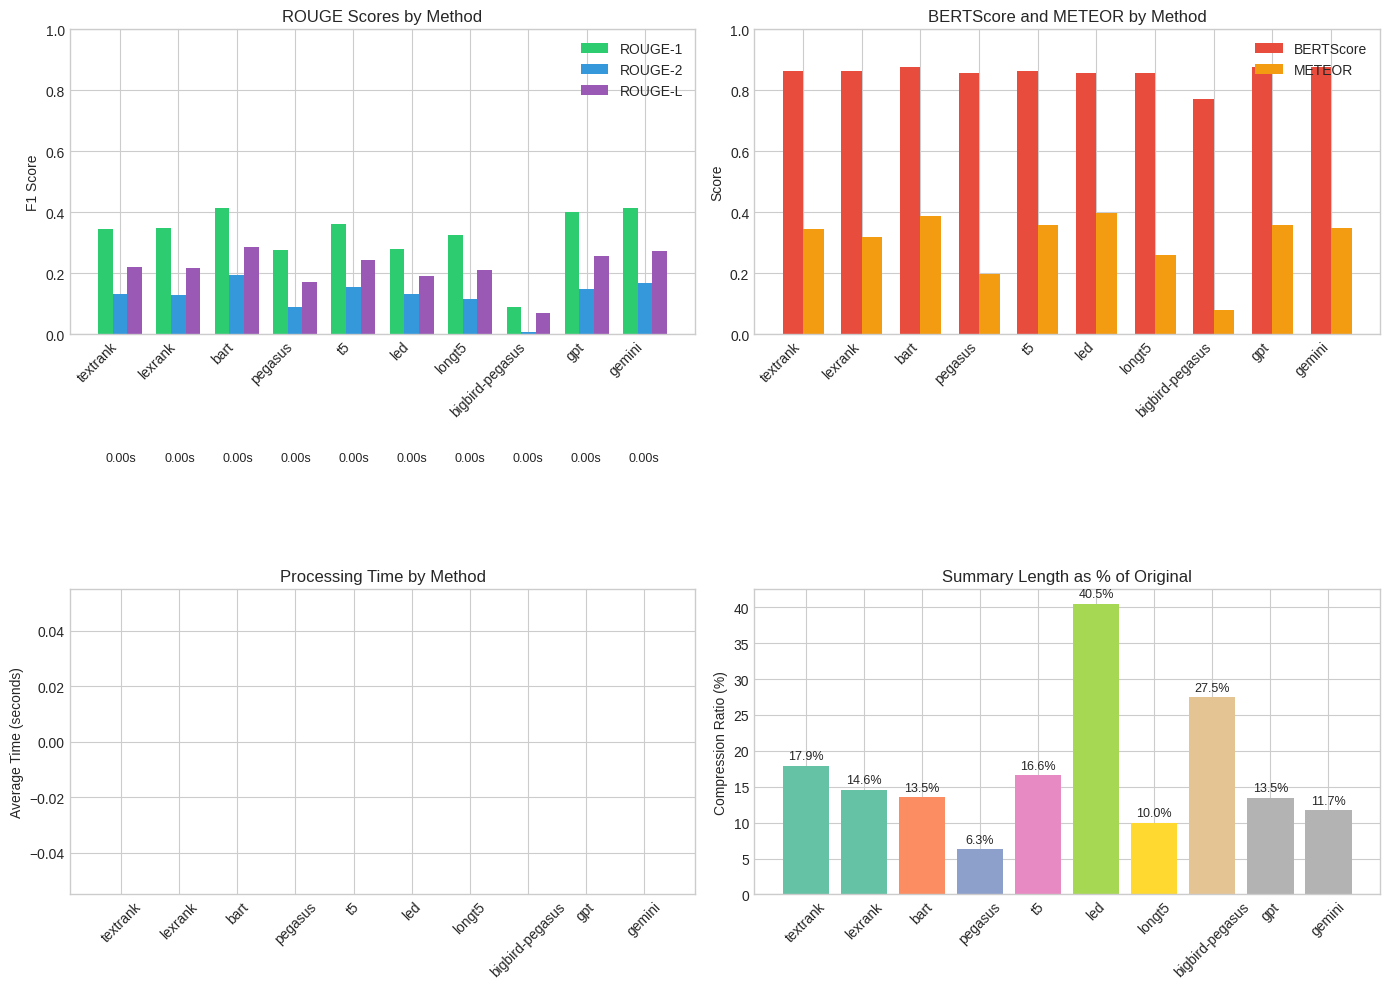


Plots saved to summarization_evaluation_plots.png


In [15]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods = results_df['method'].tolist()
colors = plt.cm.Set2(np.linspace(0, 1, len(methods)))

# Plot 1: ROUGE Scores Comparison
ax1 = axes[0, 0]
x = np.arange(len(methods))
width = 0.25

ax1.bar(x - width, results_df['rouge1_f1'], width, label='ROUGE-1', color='#2ecc71')
ax1.bar(x, results_df['rouge2_f1'], width, label='ROUGE-2', color='#3498db')
ax1.bar(x + width, results_df['rougeL_f1'], width, label='ROUGE-L', color='#9b59b6')

ax1.set_ylabel('F1 Score')
ax1.set_title('ROUGE Scores by Method')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1)

# Plot 2: BERTScore and METEOR
ax2 = axes[0, 1]
x = np.arange(len(methods))
width = 0.35

ax2.bar(x - width/2, results_df['bertscore_f1'], width, label='BERTScore', color='#e74c3c')
ax2.bar(x + width/2, results_df['meteor'], width, label='METEOR', color='#f39c12')

ax2.set_ylabel('Score')
ax2.set_title('BERTScore and METEOR by Method')
ax2.set_xticks(x)
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.legend()
ax2.set_ylim(0, 1)

# Plot 3: Processing Time
ax3 = axes[1, 0]
bars = ax3.bar(methods, results_df['avg_time_seconds'], color=colors)
ax3.set_ylabel('Average Time (seconds)')
ax3.set_title('Processing Time by Method')
ax3.tick_params(axis='x', rotation=45)

for bar, val in zip(bars, results_df['avg_time_seconds']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.2f}s', ha='center', va='bottom', fontsize=9)

# Plot 4: Compression Ratio
ax4 = axes[1, 1]
bars = ax4.bar(methods, results_df['compression_ratio_mean'] * 100, color=colors)
ax4.set_ylabel('Compression Ratio (%)')
ax4.set_title('Summary Length as % of Original')
ax4.tick_params(axis='x', rotation=45)

for bar, val in zip(bars, results_df['compression_ratio_mean'] * 100):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('summarization_evaluation_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlots saved to summarization_evaluation_plots.png")

## 7. Detailed Comparison: Sample Outputs

In [16]:
sample_idx = 0

print(f"\n{'='*80}")
print(f"SAMPLE ARTICLE #{sample_idx + 1}")
print(f"{'='*80}")
print(f"\n{articles[sample_idx][:1000]}...")

print(f"\n{'='*80}")
print("REFERENCE SUMMARY (Ground Truth)")
print(f"{'='*80}")
print(f"\n{references[sample_idx]}")

print(f"\n{'='*80}")
print("GENERATED SUMMARIES")
print(f"{'='*80}")

for method, preds in all_predictions.items():
    print(f"\n--- {method.upper()} ---")
    print(preds[sample_idx] if preds[sample_idx] else "[Empty summary]")


SAMPLE ARTICLE #1

(CNN) I see signs of a revolution everywhere. I see it in the op-ed pages of the newspapers, and on the state ballots in nearly half the country. I see it in politicians who once preferred to play it safe with this explosive issue but are now willing to stake their political futures on it. I see the revolution in the eyes of sterling scientists, previously reluctant to dip a toe into this heavily stigmatized world, who are diving in head first. I see it in the new surgeon general who cites data showing just how helpful it can be. I see a revolution in the attitudes of everyday Americans. For the first time a majority, 53%, favor its legalization, with 77% supporting it for medical purposes. Support for legalization has risen 11 points in the past few years alone. In 1969, the first time Pew asked the question about legalization, only 12% of the nation was in favor. I see a revolution that is burning white hot among young people, but also shows up among the parents a

## 8. Statistical Summary and Recommendations

In [17]:
print("\n" + "="*80)
print("METHOD RANKINGS")
print("="*80)

metrics_to_rank = ['rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'bertscore_f1', 'meteor']

for metric in metrics_to_rank:
    sorted_df = results_df.sort_values(metric, ascending=False)
    print(f"\nTop methods by {metric}:")
    for i, (_, row) in enumerate(sorted_df.iterrows(), 1):
        print(f"  {i}. {row['method']}: {row[metric]:.4f}")

# Overall score (average of normalized metrics)
print(f"\n{'='*80}")
print("OVERALL RANKING (Average of all metrics)")
print(f"{'='*80}")

# Normalize each metric to 0-1 scale and compute average
normalized_df = results_df.copy()
for metric in metrics_to_rank:
    min_val = normalized_df[metric].min()
    max_val = normalized_df[metric].max()
    if max_val > min_val:
        normalized_df[f'{metric}_norm'] = (normalized_df[metric] - min_val) / (max_val - min_val)
    else:
        normalized_df[f'{metric}_norm'] = 1.0

norm_cols = [f'{m}_norm' for m in metrics_to_rank]
normalized_df['overall_score'] = normalized_df[norm_cols].mean(axis=1)

final_ranking = normalized_df.sort_values('overall_score', ascending=False)[['method', 'overall_score']]
for i, (_, row) in enumerate(final_ranking.iterrows(), 1):
    print(f"  {i}. {row['method']}: {row['overall_score']:.4f}")


METHOD RANKINGS

Top methods by rouge1_f1:
  1. gemini: 0.4135
  2. bart: 0.4129
  3. gpt: 0.4001
  4. t5: 0.3626
  5. lexrank: 0.3486
  6. textrank: 0.3472
  7. longt5: 0.3247
  8. led: 0.2796
  9. pegasus: 0.2761
  10. bigbird-pegasus: 0.0911

Top methods by rouge2_f1:
  1. bart: 0.1948
  2. gemini: 0.1685
  3. t5: 0.1567
  4. gpt: 0.1505
  5. led: 0.1339
  6. textrank: 0.1322
  7. lexrank: 0.1285
  8. longt5: 0.1167
  9. pegasus: 0.0907
  10. bigbird-pegasus: 0.0085

Top methods by rougeL_f1:
  1. bart: 0.2851
  2. gemini: 0.2739
  3. gpt: 0.2557
  4. t5: 0.2425
  5. textrank: 0.2211
  6. lexrank: 0.2185
  7. longt5: 0.2118
  8. led: 0.1928
  9. pegasus: 0.1731
  10. bigbird-pegasus: 0.0702

Top methods by bertscore_f1:
  1. gpt: 0.8770
  2. gemini: 0.8764
  3. bart: 0.8752
  4. t5: 0.8633
  5. textrank: 0.8631
  6. lexrank: 0.8626
  7. pegasus: 0.8580
  8. led: 0.8575
  9. longt5: 0.8572
  10. bigbird-pegasus: 0.7724

Top methods by meteor:
  1. led: 0.3974
  2. bart: 0.3888
  3. 

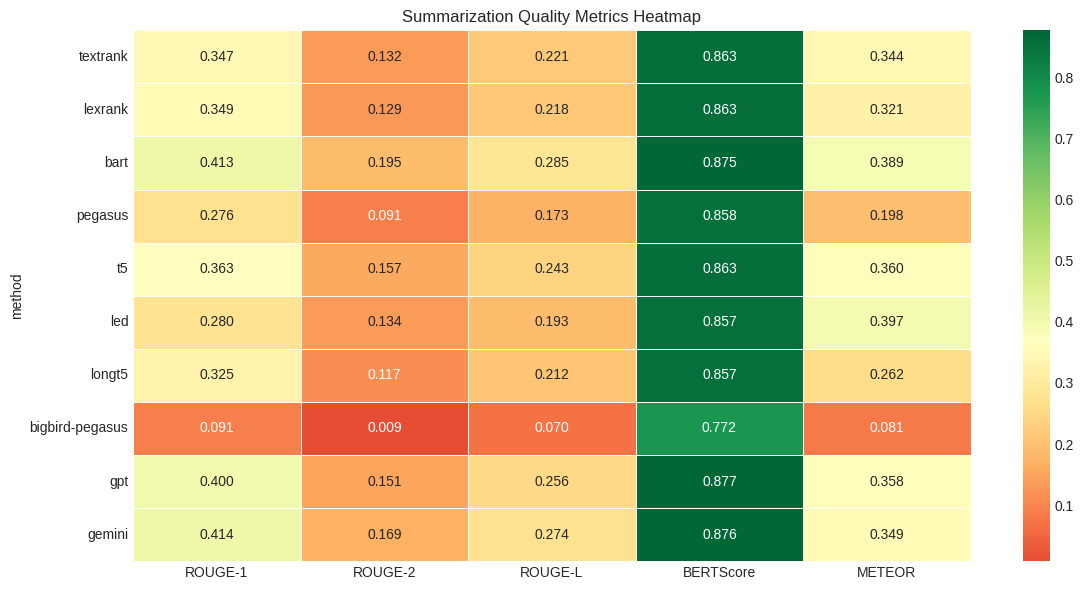


Heatmap saved to summarization_heatmap.png


In [18]:
plt.figure(figsize=(12, 6))

heatmap_data = results_df.set_index('method')[metrics_to_rank]
heatmap_data.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore', 'METEOR']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=heatmap_data.values.mean(), linewidths=0.5)
plt.title('Summarization Quality Metrics Heatmap')
plt.tight_layout()
plt.savefig('summarization_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHeatmap saved to summarization_heatmap.png")

## 9. Cache Management Utilities

In [19]:
# Cache Management Utilities

def clear_cache(method: str = None):
    """Clear cache for specific method or all methods."""
    if method:
        for cache_file in CACHE_DIR.glob(f"{method}_*.json"):
            cache_file.unlink()
            print(f"Deleted: {cache_file.name}")
    else:
        for cache_file in CACHE_DIR.glob("*.json"):
            cache_file.unlink()
            print(f"Deleted: {cache_file.name}")

def list_cache_files():
    """List all cache files with metadata."""
    cache_files = sorted(CACHE_DIR.glob("*.json"))
    if not cache_files:
        print("No cache files found")
        return
    
    print(f"\nFound {len(cache_files)} cache files:")
    print("-" * 80)
    for cache_file in cache_files:
        with open(cache_file) as f:
            data = json.load(f)
        meta = data.get("metadata", {})
        num_summaries = len(data.get("summaries", {}))
        print(f"{cache_file.name}")
        print(f"  Created: {meta.get('created_at', 'unknown')}")
        print(f"  Summaries: {num_summaries}")
        print(f"  Sample size: {meta.get('sample_size', 'unknown')}")
        print()

# List current cache files
list_cache_files()

# Example usage:
# clear_cache("bart")  # Clear BART cache only
# clear_cache()  # Clear all caches


Found 10 cache files:
--------------------------------------------------------------------------------
bart_short.json
  Created: 2026-01-30T13:45:52.836201
  Summaries: 100
  Sample size: 100

bigbird-pegasus_short.json
  Created: 2026-01-30T16:48:35.656535
  Summaries: 100
  Sample size: 100

gemini_short.json
  Created: 2026-02-02T07:31:40.930531
  Summaries: 100
  Sample size: 100

gpt_short.json
  Created: 2026-02-02T07:29:23.376714
  Summaries: 100
  Sample size: 100

led_short.json
  Created: 2026-01-30T14:31:15.993169
  Summaries: 100
  Sample size: 100

lexrank_short.json
  Created: 2026-01-30T13:30:34.030325
  Summaries: 100
  Sample size: 100

longt5_short.json
  Created: 2026-01-30T14:48:57.446199
  Summaries: 100
  Sample size: 100

pegasus_short.json
  Created: 2026-01-30T13:57:39.882227
  Summaries: 100
  Sample size: 100

t5_short.json
  Created: 2026-01-30T14:12:03.515488
  Summaries: 100
  Sample size: 100

textrank_short.json
  Created: 2026-01-30T13:30:00.584016
  